In [28]:
"""
Author: Seung Won Joeng
Modifier: Kwanyeob Jung, Jaeshin Cho
"""
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
%matplotlib inline               
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from kneed import KneeLocator
import seaborn as sb
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [29]:
"""
            TASK 1-2
"""

# Read csv from current path.
def read_csv():
    df1 = pd.read_csv('2020_US_weekly_symptoms_dataset.csv')
    df2 = pd.read_csv('aggregated_cc_by.csv')
    return df1, df2

df1, df2 = read_csv()
print(df1.shape)
print(df2.shape)

(624, 430)
(98434, 62)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



In [30]:
"""
            TASK 1-3
"""

# Since we are going to handle regions in USA from 2020_US_weekly_symptoms_dataset.csv
# To extract the records of USA only from dataframe
def extract_from_aggregated(df1, df2):
    # Get all region codes 
    region_codes = df1.open_covid_region_code.unique()
    result = df2[df2['open_covid_region_code'].isin(region_codes)]
    result = result.reset_index(drop = True)
    result = result[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
    return result

df2 = extract_from_aggregated(df1,df2)
print(df2.shape)

(3458, 4)


In [31]:
# Clean data in threshold num_rows * 0.05 and num_cols * 0.05
def clean_dataframe(df):
    num_rows,num_cols = df1.shape
    thresh_rows = int(num_rows * 0.05);
    thresh_cols = int(num_cols * 0.05);
    df = df.dropna(axis = 1, thresh = thresh_rows)
    df = df.dropna(axis = 0, thresh = thresh_cols)
    df = df.reset_index(drop = True)
    return df;

df1 = clean_dataframe(df1)
df_clean = clean_dataframe(df1)
print('after clean: ', df1.shape)
print('after clean: ', df_clean.shape)
print(df1.head())

after clean:  (429, 127)
after clean:  (429, 127)
  open_covid_region_code country_region_code country_region sub_region_1  \
0                  US-AK                  US  United States       Alaska   
1                  US-AK                  US  United States       Alaska   
2                  US-AK                  US  United States       Alaska   
3                  US-AK                  US  United States       Alaska   
4                  US-AK                  US  United States       Alaska   

  sub_region_1_code        date  symptom:Adrenal crisis  symptom:Ageusia  \
0             US-AK  2020-01-06                   12.69              NaN   
1             US-AK  2020-01-13                    9.56              NaN   
2             US-AK  2020-01-20                     NaN              NaN   
3             US-AK  2020-01-27                   15.31             7.47   
4             US-AK  2020-02-03                    8.81              NaN   

   symptom:Allergic conjunctivitis  

In [32]:
def convert_to_datetime(df1, df2):
    df1['date'] = pd.to_datetime(df1.date)
    df2['date'] = pd.to_datetime(df2.date)
    return df1,df2

df1, df2 = convert_to_datetime(df1,df2)

In [33]:
def daily_to_weekly(df2):
    df2['date'] = df2['date'] - pd.to_timedelta(7, unit='d')
    df2 = df2.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code', 'date'])
    return df2

print(df2['date'])
df2 = daily_to_weekly(df2)
print(df2['date'])

0      2020-03-07
1      2020-03-08
2      2020-03-09
3      2020-03-10
4      2020-03-11
          ...    
3453   2020-10-03
3454   2020-10-04
3455   2020-10-05
3456   2020-10-06
3457   2020-10-07
Name: date, Length: 3458, dtype: datetime64[ns]
0     2020-03-02
1     2020-03-09
2     2020-03-16
3     2020-03-23
4     2020-03-30
         ...    
508   2020-09-07
509   2020-09-14
510   2020-09-21
511   2020-09-28
512   2020-10-05
Name: date, Length: 513, dtype: datetime64[ns]


In [35]:
"""
            TASK 1-4
"""
# Merge two data, delete unnecessary columns
def merge_two_dfs(df1, df2):
    result = df1.merge(df2, how='inner', on=['open_covid_region_code', 'date'])
    result = result.reset_index(drop = True)
    result.drop('country_region', axis='columns', inplace=True)
    result = result.fillna(0)
    return result

final = merge_two_dfs(df1,df2)
finall= merge_two_dfs(df1,df2)
print(final.head())

  open_covid_region_code country_region_code sub_region_1 sub_region_1_code  \
0                  US-AK                  US       Alaska             US-AK   
1                  US-AK                  US       Alaska             US-AK   
2                  US-AK                  US       Alaska             US-AK   
3                  US-AK                  US       Alaska             US-AK   
4                  US-AK                  US       Alaska             US-AK   

        date  symptom:Adrenal crisis  symptom:Ageusia  \
0 2020-03-02                   14.62             0.00   
1 2020-03-09                   10.60             0.00   
2 2020-03-16                   11.69             0.00   
3 2020-03-23                   11.15            16.57   
4 2020-03-30                    8.96             8.96   

   symptom:Allergic conjunctivitis  symptom:Amblyopia  symptom:Amenorrhea  \
0                             0.00                0.0                9.97   
1                           

In [8]:
#### TASK 2!!!!!!!!!!
MAX = 100000
  
def helper(arr): 
    firstmin = MAX
    secmin = MAX
    thirdmin = MAX
    fourthmin = MAX
  
    for i in range(0, len(arr)):
        if arr[i] < firstmin: 
            thirdmin = secmin 
            secmin = firstmin 
            firstmin = arr[i] 
        elif arr[i] < secmin: 
            thirdmin = secmin 
            secmin = arr[i] 
        elif arr[i] < thirdmin:
            fourthmin = thirdmin
            thirdmin = arr[i] 
        elif arr[i] < fourthmin: 
            fourthmin = arr[i]
            
                   
    return firstmin,secmin,thirdmin,fourthmin

In [9]:
nan_array= []
index = []
top_four_sympt = []
def top_three_sympt (df):
    df_columns = np.array(df1.columns[6:-1])
    for i in df_columns:
        num_nan = len(df) - df[i].count()
        '''
        An array of the number of nan values.
        '''
        nan_array.append(num_nan)
        '''
        Using the helper method to get the index of the smallest nan values, which is the top three common symptoms. 
        '''
        first_min, second_min, thrid_min,fourthmin  = helper(nan_array)
        
        '''
        put them in the index array.
        '''
        
        small_nan = [first_min, second_min, thrid_min,fourthmin]      
        
    for j in small_nan:
        index.append(nan_array.index(j))
    
    for j in index:
        
        top_four_sympt.append(df_columns[j:j+1][0])
       
    
    return top_four_sympt[0],top_four_sympt[1],top_four_sympt[3]

top_three_sympt(df1)

('symptom:Ventricular fibrillation',
 'symptom:Dysautonomia',
 'symptom:Hemolysis')

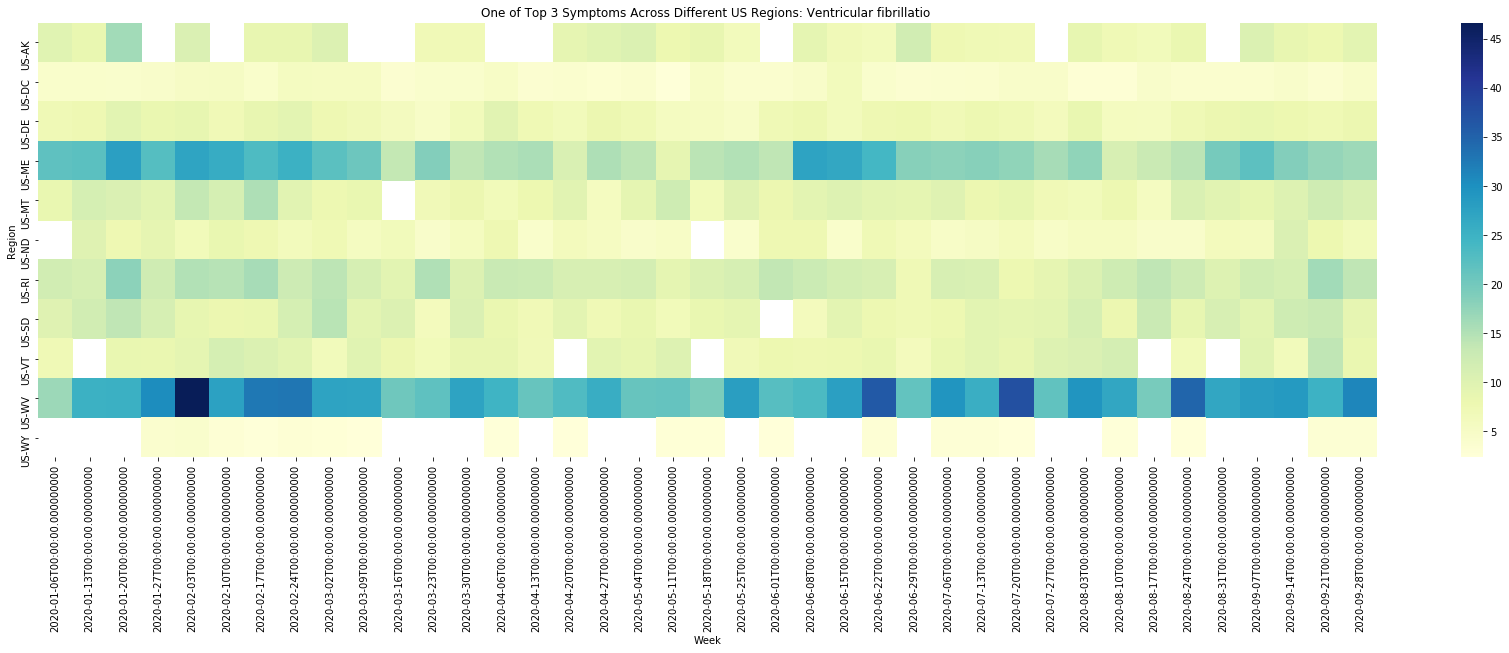

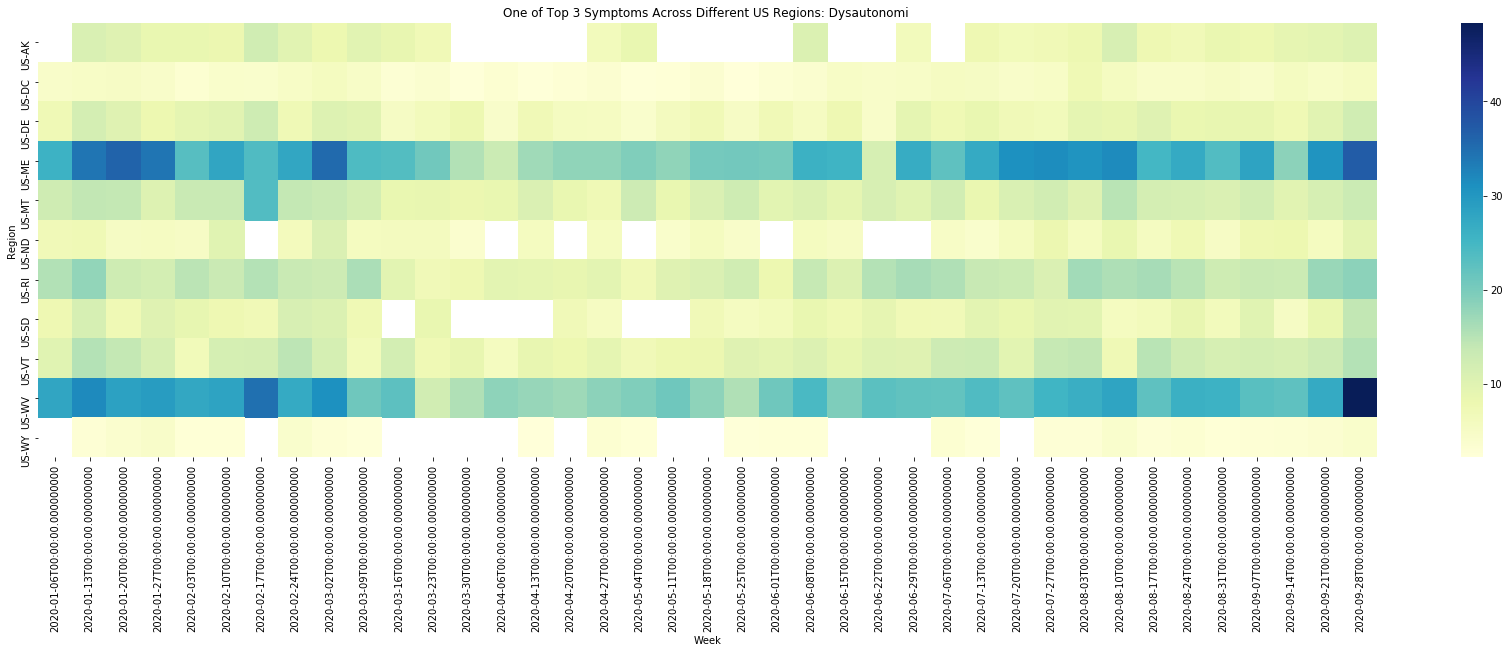

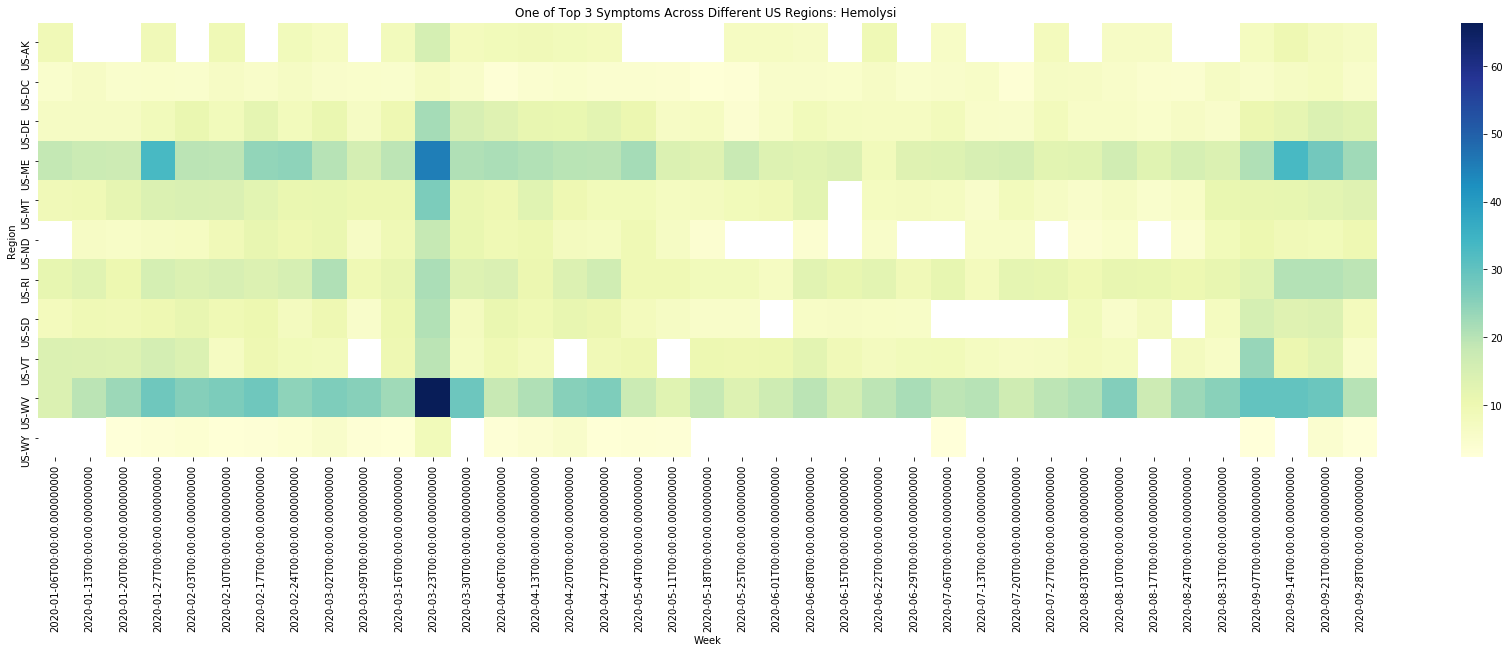

In [10]:
def plot_symptoms(sympt1, sympt2, sympt3):
    arr = []
    arr.append(sympt1)
    arr.append(sympt2)
    arr.append(sympt3)
    for i in range(0, len(arr)):
        plot_symptom = df1
        plot_symptom = plot_symptom.pivot('open_covid_region_code', 'date', arr[i])
        fig = plt.figure(figsize=(30,8))
        heat_map = sb.heatmap(plot_symptom, cmap="YlGnBu")
        heat_map.set(xlabel='Week', ylabel='Region')
        heat_map.set_title("One of Top 3 Symptoms Across Different US Regions: {} ".format(arr[i][8:-1]))

    plt.show()
    
s1,s2,s3 = top_three_sympt(df1)

plot_symptoms(s1,s2,s3)

In [11]:
def data_processing_with_standardize(df):
    not_symptoms = [colum for colum in df if not colum.startswith('symptom:')]
    
    for i in not_symptoms:
        del df[i]
    
    nan_to_zero = df.fillna(0)
    
    x = nan_to_zero.values 
    y = StandardScaler().fit_transform(x)
    df_standardize = pd.DataFrame(y)
    
    
    return df_standardize
    
    
df_standardize = data_processing_with_standardize(df1)
print(df_standardize)



          0         1         2         3         4         5         6    \
0    0.829406 -0.823823 -1.180924 -0.309700  1.132400 -1.266905 -0.715676   
1    0.367732 -0.823823 -1.180924 -0.309700  1.188003 -1.266905 -0.715676   
2   -1.042366 -0.823823 -1.180924 -0.309700  1.449171 -1.266905  0.016724   
3    1.215855  0.268193 -1.180924 -0.309700  1.701913 -0.036297 -0.715676   
4    0.257107 -0.823823 -1.180924 -0.309700  1.398622  0.060900 -0.715676   
..        ...       ...       ...       ...       ...       ...       ...   
424 -0.300442 -0.415962 -1.180924  3.901262 -0.232409 -1.266905 -0.715676   
425 -0.546767 -0.348716 -0.836552  2.348698 -0.938403 -0.896240 -0.446997   
426 -0.430242 -0.097274 -1.180924  3.454534  0.037183 -1.266905 -0.258921   
427 -0.210467 -0.287317 -1.180924  3.535091 -0.303177 -1.266905 -0.209166   
428  0.401657 -0.160134 -1.180924  3.088363 -0.500316 -1.266905 -0.231058   

          7         8         9    ...       111       112       113  \
0  

In [12]:
def PCAcompress(standardize_df):
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(standardize_df) 
    return x_pca

pca_compress = PCAcompress(df_standardize)
print(pca_compress)

[[ 9.90845898e+00  5.76506305e+00]
 [ 9.81739171e+00  5.98586960e+00]
 [ 1.12699770e+01  5.31587312e+00]
 [ 1.01011094e+01  5.39032199e+00]
 [ 1.16975726e+01  5.99409889e+00]
 [ 1.11046104e+01  5.73566014e+00]
 [ 1.17558476e+01  6.20794169e+00]
 [ 1.05646696e+01  4.88318201e+00]
 [ 1.03232652e+01  5.17472033e+00]
 [ 9.39965259e+00  4.76495779e+00]
 [ 6.37269939e+00  5.27236882e+00]
 [ 8.09505970e+00  3.73378044e+00]
 [ 6.91077032e+00  3.72622708e+00]
 [ 7.13447912e+00  4.86789528e+00]
 [ 7.41381814e+00  4.77947802e+00]
 [ 7.87654576e+00  4.76173437e+00]
 [ 8.10537804e+00  4.04402885e+00]
 [ 7.55401134e+00  4.59011472e+00]
 [ 7.35912109e+00  6.37200585e+00]
 [ 5.81891532e+00  5.39394239e+00]
 [ 6.23508459e+00  4.47241895e+00]
 [ 7.31955759e+00  5.71815955e+00]
 [ 7.34801418e+00  4.08867042e+00]
 [ 8.05768615e+00  5.81103533e+00]
 [ 8.37616914e+00  5.31815126e+00]
 [ 8.57479958e+00  4.74039596e+00]
 [ 8.40688193e+00  5.37925832e+00]
 [ 8.59489676e+00  4.74309925e+00]
 [ 8.94894572e+00  5

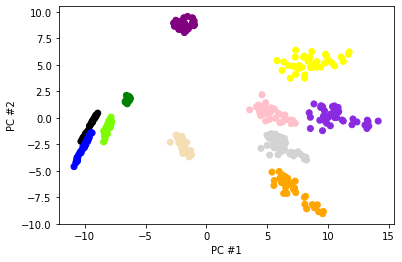

In [13]:
def plot(df,df1):
    target = df1['open_covid_region_code']
    
    colors = {'US-AK':'yellow', 'US-DC':'green', 'US-DE':'wheat', 
              'US-HI':'red', 'US-ID':'olive', 'US-ME':'black', 
              'US-MT':'orange', 'US-ND':'pink', 'US-NE':'magenta',
              'US-NH':'peru', 'US-NM':'cyan', 'US-RI':'lawngreen', 
              'US-SD':'lightgray', 'US-VT':'blueviolet', 'US-WV':'blue', 'US-WY':'purple'}

    plt.scatter(df[:, 0], df[:, 1], c= target.map(colors))
    plt.xlabel("PC #1")
    plt.ylabel("PC #2")
    plt.show()
    
    return 

pca = PCAcompress(df_standardize)
plot(pca,df_clean)

In [14]:
def sihlouette (df):
    not_symptoms = [colum for colum in df if not colum.startswith('symptom:')]

    for i in not_symptoms:
        del df[i]

    y = StandardScaler().fit_transform(df)
    df_standardize = pd.DataFrame(y)

    range_cl = list(range(5, 40))

    avg = 0
    K = 0

    for n in range_cl:
        cl = KMeans(n_clusters=n)
        cl_fit = cl.fit_predict(df_standardize)
        sil_avg = silhouette_score(df_standardize, cl_fit)
        print("Number of cluster =", n, "The silhouette score is :", sil_avg)
        if sil_avg > avg:
            avg = sil_avg
            k = n

    print("The best number of cluster : ", k)
    
sihlouette(final)

Number of cluster = 5 The silhouette score is : 0.3456823574006864
Number of cluster = 6 The silhouette score is : 0.3599440443602307
Number of cluster = 7 The silhouette score is : 0.3734092728213051
Number of cluster = 8 The silhouette score is : 0.3889454176908375
Number of cluster = 9 The silhouette score is : 0.4134177966562115
Number of cluster = 10 The silhouette score is : 0.44866437786447483
Number of cluster = 11 The silhouette score is : 0.44107336033946803
Number of cluster = 12 The silhouette score is : 0.444869487867514
Number of cluster = 13 The silhouette score is : 0.43945852595166257
Number of cluster = 14 The silhouette score is : 0.43894730366683915
Number of cluster = 15 The silhouette score is : 0.4242547001270248
Number of cluster = 16 The silhouette score is : 0.4212843866335798
Number of cluster = 17 The silhouette score is : 0.3996611782493375
Number of cluster = 18 The silhouette score is : 0.41053728651827354
Number of cluster = 19 The silhouette score is : 

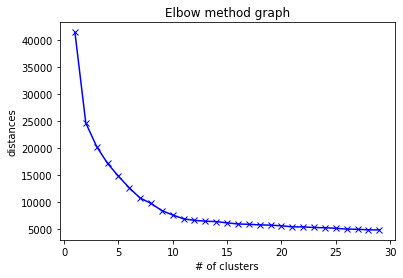

Elbow point:  9


In [15]:
def elbow_method(df):
    
    not_symptoms = [colum for colum in df if not colum.startswith('symptom:')]

    for i in not_symptoms:
        del df[i]
        
    y = StandardScaler().fit_transform(df)
    df_standardize = pd.DataFrame(y)
    
    distance = [] 
    
    
    K = range(1,30)
    
    for i in K:
        mean = KMeans(n_clusters = i)
        mean = mean.fit(df_standardize)
        distance.append(mean.inertia_)
    
    plt.plot(K,distance, 'bx-')
    plt.xlabel("# of clusters")
    plt.ylabel ("distances")
    plt.title("Elbow method graph")
    plt.show()

    
    kl = KneeLocator (K, distance, curve="convex", direction="decreasing")
    print("Elbow point: ", kl.elbow)
    
    return 
    

elbow_method(final)



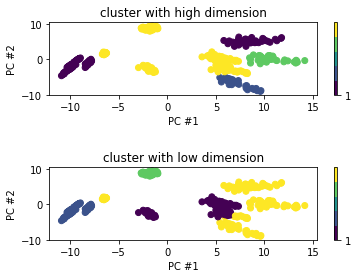

In [16]:
#Kmeans 
def kmeans_elbow(df_standardize, pca):
    high_k = KMeans(n_clusters = 8, random_state = 0)
    high_k.fit(df_standardize)
    pred_hig_k = high_k.predict(df_standardize)

    low_k = KMeans (n_clusters = 8, random_state =0)
    low_k.fit(pca)
    pred_low_k = low_k.predict(pca)

    plt.subplot(2,1,1)
    plt.subplots_adjust(hspace=1)
    plt.scatter(pca[:,0], pca[:,1], c =pred_hig_k, cmap = plt.cm.get_cmap('viridis',5))
    plt.colorbar(ticks= [0,1])
    plt.clim(1,4)
    plt.xlabel ("PC #1")
    plt.ylabel ("PC #2")
    plt.title ("cluster with high dimension")

    plt.subplot(2,1,2)
    plt.subplots_adjust(hspace=1)
    plt.scatter(pca[:,0], pca[:,1], c =pred_low_k, cmap = plt.cm.get_cmap('viridis',5))
    plt.colorbar(ticks= [0,1])
    plt.clim(1,4)
    plt.xlabel ("PC #1")
    plt.ylabel ("PC #2")
    plt.title ("cluster with low dimension")
    
    return

kmeans_elbow(df_standardize, pca)

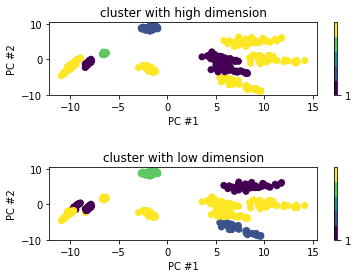

In [17]:
def kmeans_sil(df_standardize, pca):
    high_k = KMeans(n_clusters = 10, random_state = 0)
    high_k.fit(df_standardize)
    pred_hig_k = high_k.predict(df_standardize)

    low_k = KMeans (n_clusters = 10, random_state =0)
    low_k.fit(pca)
    pred_low_k = low_k.predict(pca)

    plt.subplot(2,1,1)
    plt.subplots_adjust(hspace=1)
    plt.scatter(pca[:,0], pca[:,1], c =pred_hig_k, cmap = plt.cm.get_cmap('viridis',5))
    plt.colorbar(ticks= [0,1])
    plt.clim(1,4)
    plt.xlabel ("PC #1")
    plt.ylabel ("PC #2")
    plt.title ("cluster with high dimension")

    plt.subplot(2,1,2)
    plt.subplots_adjust(hspace=1)
    plt.scatter(pca[:,0], pca[:,1], c =pred_low_k, cmap = plt.cm.get_cmap('viridis',5))
    plt.colorbar(ticks= [0,1])
    plt.clim(1,4)
    plt.xlabel ("PC #1")
    plt.ylabel ("PC #2")
    plt.title ("cluster with low dimension")
    
    return

kmeans_sil(df_standardize, pca)

In [24]:
"""
            TASK 3
"""

# df: mereged data
# Case1) To keep all data from some regions in the val set and train on the rest
def split_data_regions(df):
    regions = df.open_covid_region_code.unique()
    col_name = 'open_covid_region_code'
    kf = KFold()
    for train_index, val_index in kf.split(regions):
        
        train, validation = regions[train_index], regions[val_index]
        
        train_df = df[df[col_name].isin(train)]
        val_df = df[df[col_name].isin(validation)]
        
        X_train = train_df.iloc[:, 5:-1]
        Y_train = train_df['hospitalized_new']
#         print("X_train: \n", X_train.head(3))
#         print("Y_train: \n", Y_train.head(3))
        
        X_val = val_df.iloc[:, 5:-1]
        Y_val = val_df['hospitalized_new']
#         print("X_validation: \n", X_val.head(3))
#         print("Y_validation: \n", Y_val.head(3))
#         X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         X_val = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         Y_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         Y_val = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
        yield X_train, Y_train, X_val, Y_val, train

    
# Case2) To keep data for the last couple of timepoints (keep data after 2020-08-10) from all regions in the va
# set and train on the rest
# df: merged data // date: date as string
def split_data_time(df, d):
    # Convert to datetime from String
    date = datetime.strptime(d, '%Y-%m-%d')
    
    train_df = df[df["date"] <= date]
    val_df = df[df["date"] > date]
    
    X_train = train_df.iloc[:, 5:-1]
    Y_train = train_df['hospitalized_new']
    
    X_val = val_df.iloc[:, 5:-1]
    Y_val = val_df['hospitalized_new']
    return X_train, Y_train, X_val, Y_val, train_df['date']



In [25]:
"""
            TASK 3: KNeighborsRegressor
            @Params: k:int, X_train, Y_train, X_val: dataframe
"""

def KNN_regression(k, X_train, Y_train, X_val):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, Y_train)
    pred = neigh.predict(X_val)
    return pred


"""
            TASK 3: DecisionTreeRegressor
            @Params: l:int, X_train, Y_train, X_val: dataframe
"""
def DecisionTree_regression(l, X_train, Y_train, X_val):
    model = DecisionTreeRegressor(min_samples_leaf=l)
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    return pred


[BASED ON REGION] K:  40
[BASED ON REGION] Minimum RMSE:  23.093681058651296
[BASED ON REGION] Regions used in Train: 
 ['US-AK' 'US-DC' 'US-DE' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


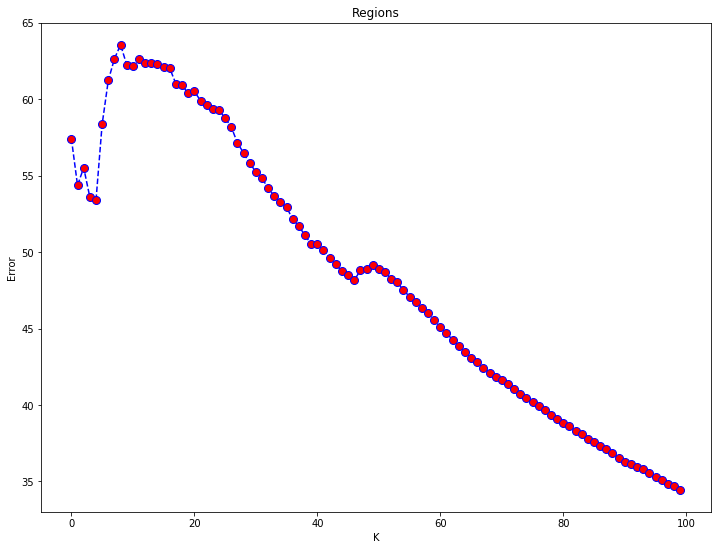

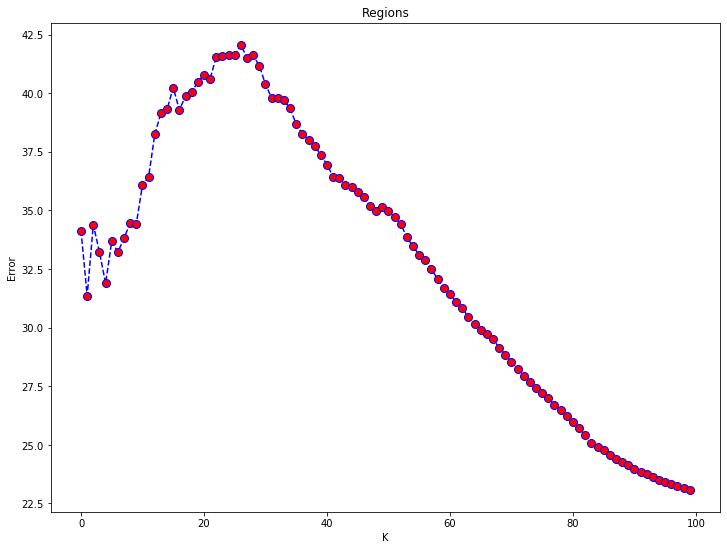

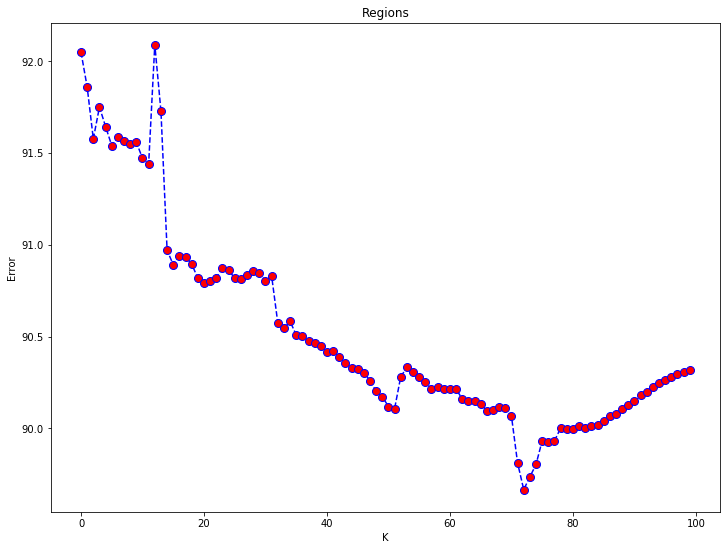

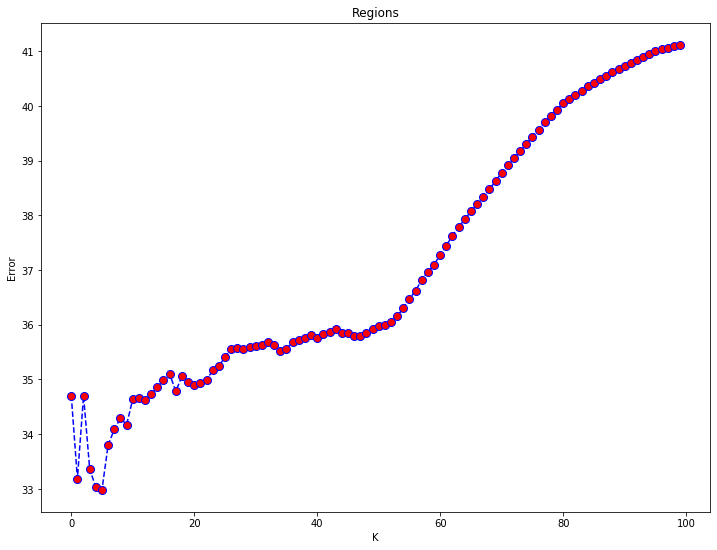

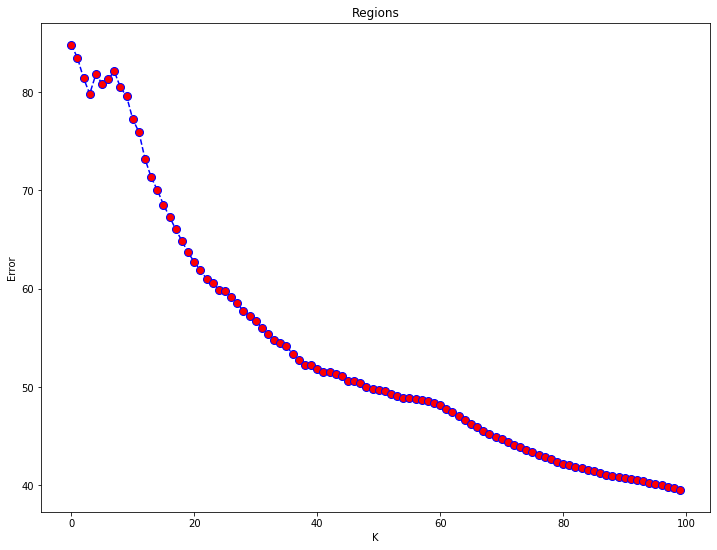

In [36]:
"""
            TASK 3: KNeighborsRegressor based on regions
"""

errors_knn = []
errors_tmp = []
fold_regions = []

for X_train, Y_train, X_val, Y_val, train in split_data_regions(finall): 
    for n in range(100):
        pred = KNN_regression(n+1, X_train, Y_train, X_val)
        mse = mean_squared_error(Y_val, pred, squared=False)
        errors_knn.append(mse)
        errors_tmp.append(mse)
        fold_regions.append(train)
        
    plt.figure(figsize=(12,9))
    plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
    plt.title('Regions')
    plt.ylabel('Error')
    plt.xlabel('K')
    errors_tmp = []
        

err = np.array(errors_knn)
min_index = np.argmin(err)
k = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]


print('[BASED ON REGION] K: ', k)
print('[BASED ON REGION] Minimum RMSE: ', min_err)
print('[BASED ON REGION] Regions used in Train: \n', min_reg)


[BASED ON TIME] K:  2
[BASED ON TIME] Minimum RMSE:  33.017497656775134
[BASED ON TIME] Dates used in Train: 
 ['US-ME' 'US-MT' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY'] 
[BASED ON TIME] Time:  2020-08-01


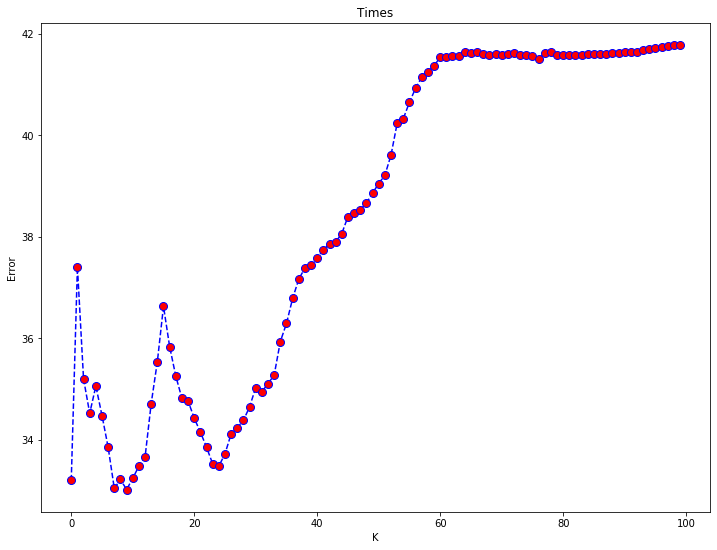

In [37]:
"""
            TASK 3: KNeighborsRegressor based on times
"""

errors_knn = []
errors_tmp = []
fold_times = []
d = '2020-08-01'

X_train, Y_train, X_val, Y_val, train = split_data_time(finall, d)

for n in range(100):
    pred = KNN_regression(n+1, X_train, Y_train, X_val)
    mse = mean_squared_error(Y_val, pred, squared=False)
    errors_knn.append(mse)
    errors_tmp.append(mse)
    fold_times.append(train)
    
plt.figure(figsize=(12,9))
plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
plt.title('Times')
plt.ylabel('Error')
plt.xlabel('K')

# for X_train, Y_train, X_val, Y_val, train in split_data_time(final, d):
#     for n in range(100):
#         pred = KNN_regression(n+1, X_train, Y_train, X_val)
#         mse = mean_squared_error(Y_val, pred, squared=False)
#         errors_knn.append(mse)
#         errors_tmp.append(mse)
#         fold_times.append(train)
    
#     plt.figure(figsize=(12,9))
#     plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
#     plt.title('Times')
#     plt.ylabel('Error')
#     plt.xlabel('K')
#     errors_tmp = []

err = np.array(errors_knn)
min_index = np.argmin(err)
k = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]

print('[BASED ON TIME] K: ', k)
print('[BASED ON TIME] Minimum RMSE: ', min_err)
print('[BASED ON TIME] Dates used in Train: \n', min_reg, '\n[BASED ON TIME] Time: ', d)

[BASED ON REGION] Leaf:  22
[BASED ON REGION] Minimum RMSE:  20.35295426374129
[BASED ON REGION] Regions used in Train: 
 ['US-AK' 'US-DC' 'US-DE' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


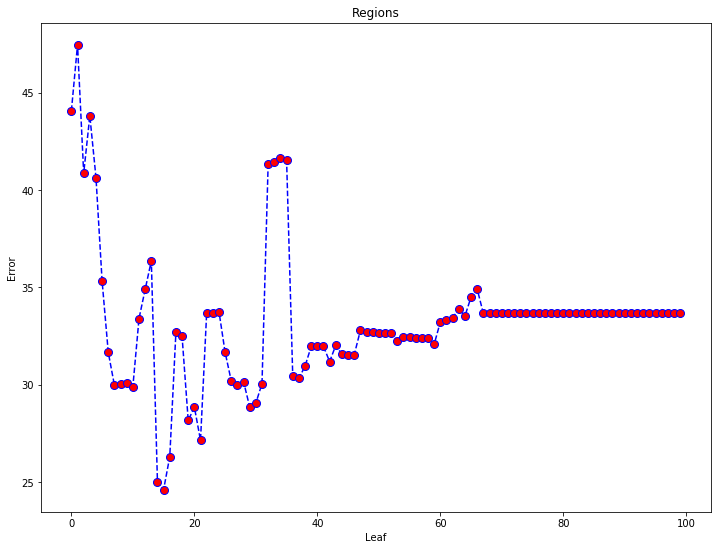

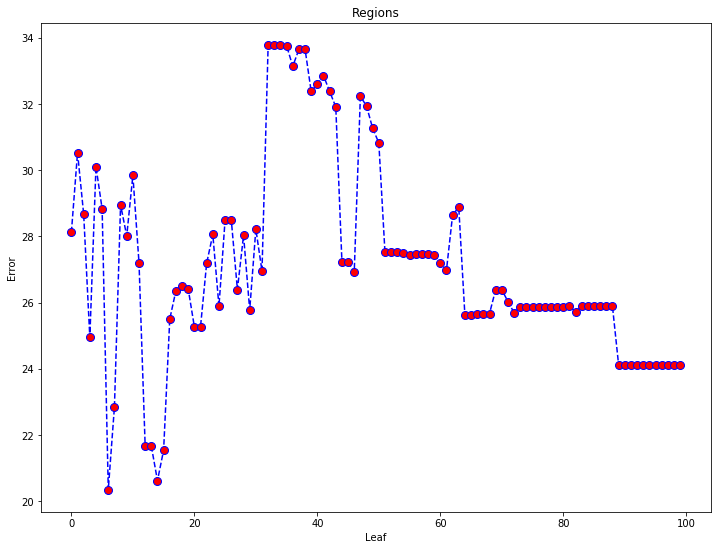

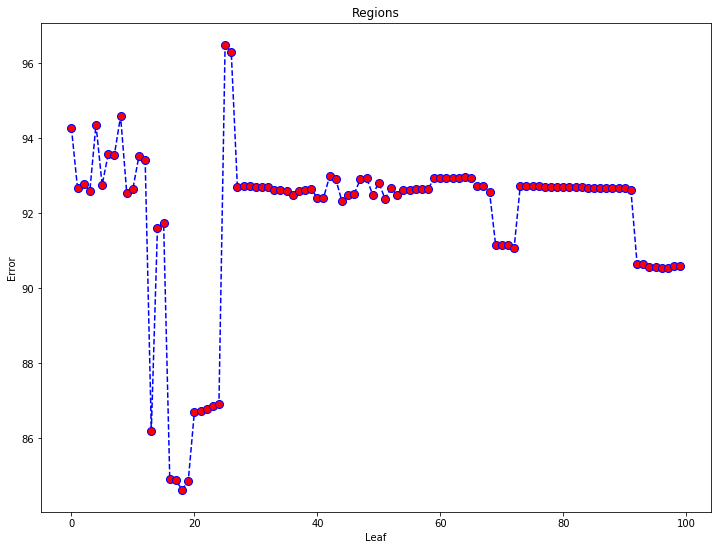

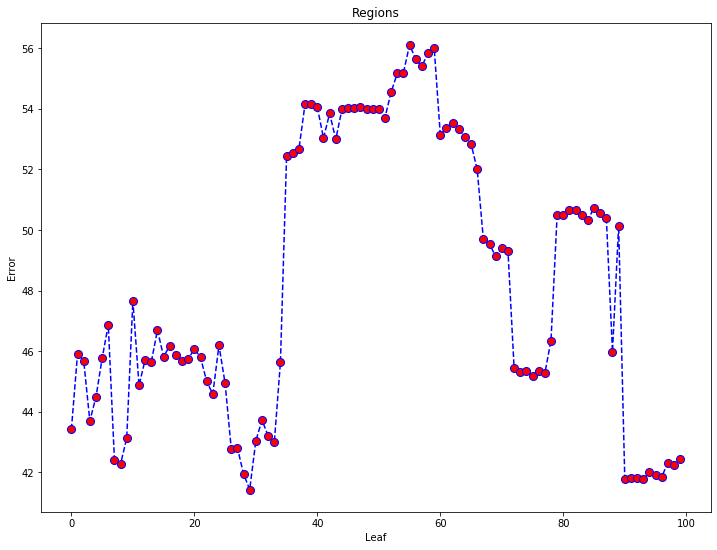

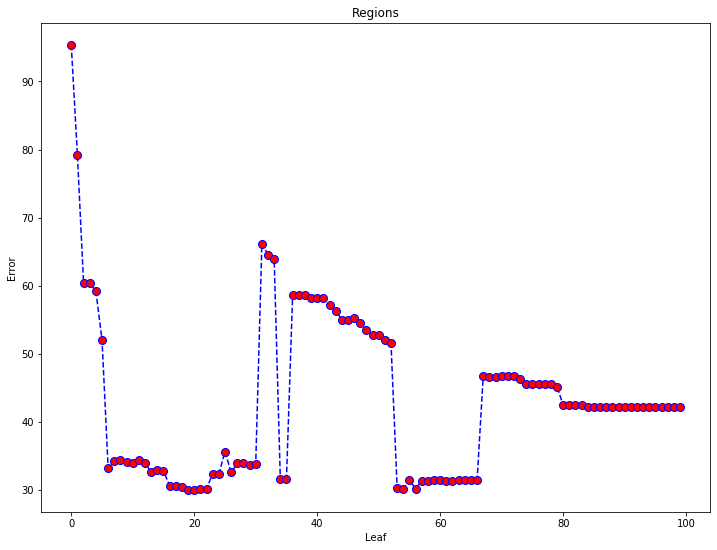

In [38]:
"""
            TASK 3: DecisionTreeRegressor based on regions
"""

errors_tmp = []
errors_dt = []
fold_regions = []


for X_train, Y_train, X_val, Y_val, train in split_data_regions(finall):
    for l in range(100):
        pred = DecisionTree_regression(l+1, X_train, Y_train, X_val)
        mse = mean_squared_error(Y_val, pred, squared=False)
        errors_dt.append(mse)
        errors_tmp.append(mse)
        fold_regions.append(train)
        
    plt.figure(figsize=(12,9))
    plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
    plt.title('Regions')
    plt.ylabel('Error')
    plt.xlabel('Leaf')
    errors_tmp = []
        

err = np.array(errors_dt)
min_index = np.argmin(err)
l = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]

print('[BASED ON REGION] Leaf: ', l)
print('[BASED ON REGION] Minimum RMSE: ', min_err)
print('[BASED ON REGION] Regions used in Train: \n', min_reg)





[BASED ON TIME] L:  7
[BASED ON TIME] Minimum RMSE:  32.91110358200317
[BASED ON TIME] Times used in Train: 
 0     2020-03-02
1     2020-03-09
2     2020-03-16
3     2020-03-23
4     2020-03-30
         ...    
328   2020-06-29
329   2020-07-06
330   2020-07-13
331   2020-07-20
332   2020-07-27
Name: date, Length: 243, dtype: datetime64[ns] 
[BASED ON TIME] Time:  2020-08-01


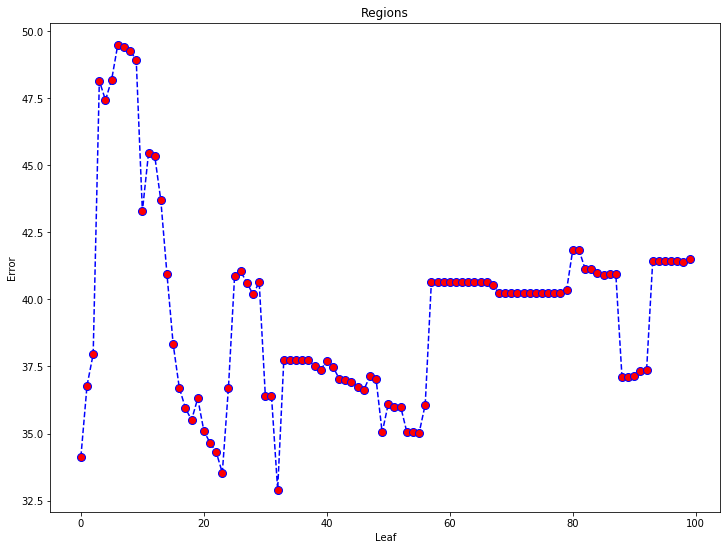

In [39]:

"""
            TASK 3: DecisionTreeRegressor based on times
"""
errors_tmp = []
errors_dt = []
fold_times = []
d = '2020-08-01'

X_train, Y_train, X_val, Y_val, train = split_data_time(finall, d)

for l in range(100):
    pred = DecisionTree_regression(l+1, X_train, Y_train, X_val)
    mse = mean_squared_error(Y_val, pred,squared=False)
    errors_dt.append(mse)
    errors_tmp.append(mse)
    fold_times.append(train)

plt.figure(figsize=(12,9))
plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
plt.title('Regions')
plt.ylabel('Error')
plt.xlabel('Leaf')
errors_tmp = []


err = np.array(errors_dt)
min_index = np.argmin(err)
l = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_times[min_index]

print('\n')
print('[BASED ON TIME] L: ', l)
print('[BASED ON TIME] Minimum RMSE: ', min_err)
print('[BASED ON TIME] Times used in Train: \n', min_reg, '\n[BASED ON TIME] Time: ', d)
